In [1]:
import os
from pathlib import Path

# Definir rutas usando Path
base_dir = Path(r"C:\Users\matia\Documents\Diplomado Machine Learning\Actividad Análisis de Datos\data")
train_dir = base_dir / "train"
test_dir = base_dir / "test"

print("¿Train existe?:", train_dir.exists())
print("¿Test existe?:", test_dir.exists())


¿Train existe?: True
¿Test existe?: True


Se definen las rutas y se comprueba su existencia.

In [4]:
# Listar nombre de clases
classes      = [d.name for d in train_dir.iterdir() if d.is_dir()]
test_classes = [d.name for d in test_dir.iterdir() if d.is_dir()]

print("Clases (train):", classes)
print("Clases (test) :", test_classes)

Clases (train): ['benign', 'malignant']
Clases (test) : ['benign', 'malignant']


Se obtienen los nombres de las carpetas (clases).

In [5]:
# ¿Cuántos datos hay? Contar imágenes por clase para las rutas Train y Test
for split, directory, cls_list in [("train", train_dir, classes),
                                   ("test",  test_dir,  test_classes)]:
    print(f"\nRecuento por clase en {split}:")
    for cls in cls_list:
        n = len(list((directory/cls).glob("*")))
        print(f"  {cls:15s}: {n:4d}")


Recuento por clase en train:
  benign         : 1440
  malignant      : 1197

Recuento por clase en test:
  benign         :  360
  malignant      :  300


Se contabilizan las imágenes que hay en cada conjunto de datos. Esto permite evaluar si el dataset está balanceado o desequilibrado.

In [4]:
# Inspección básica de las imágenes:

from PIL import Image
import numpy as np

# Analizar 5 imágenes de cada clase
for clase in classes:
    print(f"Clase:{clase}")
    imagenes = list((train_dir / clase).glob("*"))[:5]
    for idx, img_path in enumerate(imagenes):
        with Image.open(img_path) as img:
            img_array = np.array(img)
            print(f"  Imagen {idx+1}:")
            print("    Tamaño (ancho x alto):", img.size)
            print("    Nº de canales:", len(img.getbands()))
            print("    Valor mínimo de píxel:", img_array.min())
            print("    Valor máximo de píxel:", img_array.max())
    print("-" * 30)

Clase:benign
  Imagen 1:
    Tamaño (ancho x alto): (224, 224)
    Nº de canales: 3
    Valor mínimo de píxel: 6
    Valor máximo de píxel: 255
  Imagen 2:
    Tamaño (ancho x alto): (224, 224)
    Nº de canales: 3
    Valor mínimo de píxel: 8
    Valor máximo de píxel: 234
  Imagen 3:
    Tamaño (ancho x alto): (224, 224)
    Nº de canales: 3
    Valor mínimo de píxel: 30
    Valor máximo de píxel: 232
  Imagen 4:
    Tamaño (ancho x alto): (224, 224)
    Nº de canales: 3
    Valor mínimo de píxel: 13
    Valor máximo de píxel: 215
  Imagen 5:
    Tamaño (ancho x alto): (224, 224)
    Nº de canales: 3
    Valor mínimo de píxel: 45
    Valor máximo de píxel: 252
------------------------------
Clase:malignant
  Imagen 1:
    Tamaño (ancho x alto): (224, 224)
    Nº de canales: 3
    Valor mínimo de píxel: 9
    Valor máximo de píxel: 200
  Imagen 2:
    Tamaño (ancho x alto): (224, 224)
    Nº de canales: 3
    Valor mínimo de píxel: 10
    Valor máximo de píxel: 240
  Imagen 3:
    Tam

Se selecciona un muestra de las imágenes (5), y se mide: Resolución, N° de canales, valor mínimo y máximo de píxel. Con esto se busca confirmar que las imágenes complen requisitos de resolución y formato, además de detectar outliers (imágenes corruptas o con escala de grises).
Se observa que todas las imágenes están en RGB (3 canales) y la resolución es de 224x224. Sin detectarse valores extraños.

In [9]:
# Preprocesamiento de datos: Limpieza de datos, archivos corruptos y anomalías
from PIL import UnidentifiedImageError
problemas, anomalos = [], []

# Detectar corruptos
for split_dir in (train_dir, test_dir):
    for cls in split_dir.iterdir():
        for img_path in cls.glob("*"):
            try:
                with Image.open(img_path) as im:
                    im.verify()
            except (UnidentifiedImageError, OSError):
                problemas.append(img_path)

# Detectar tamaños/canales distintos a 224×224×3
for split_dir in (train_dir, test_dir):
    for cls in split_dir.iterdir():
        for img_path in cls.glob("*"):
            try:
                with Image.open(img_path) as im:
                    if im.size!=(224,224) or len(im.getbands())!=3:
                        anomalos.append(img_path)
            except:
                pass

if not problemas:
    print("No se detectaron archivos corruptos.")
else:
    print(f"Archivos corruptos detectados: {len(problemas)}")

if not anomalos:
    print("No se detectaron imágenes que no cumplan con los requisitos de tamaño/canales.")
else:
    print(f"Imágenes con tamaño/canales anómalos detectadas: {len(anomalos)}")

# Eliminar los detectados
eliminados = 0
for p in set(problemas + anomalos):
    try:
        p.unlink()
        eliminados += 1
    except Exception as e:
        print(f"No se pudo eliminar {p}: {e}")

print(f"Total de archivos eliminados: {eliminados}")

No se detectaron archivos corruptos.
No se detectaron imágenes que no cumplan con los requisitos de tamaño/canales.
Total de archivos eliminados: 0


Se detectan y se eliminan las imágenes que PIL no puede abrir, o que no cumplen con los requisitos de tamaño/canales (224x224x3), de esta forma se garantiza que el modelo reciba solo datos válidos para el aprendizaje.

Antes: 6.0 - 255.0 → Después: 0.0 - 1.0


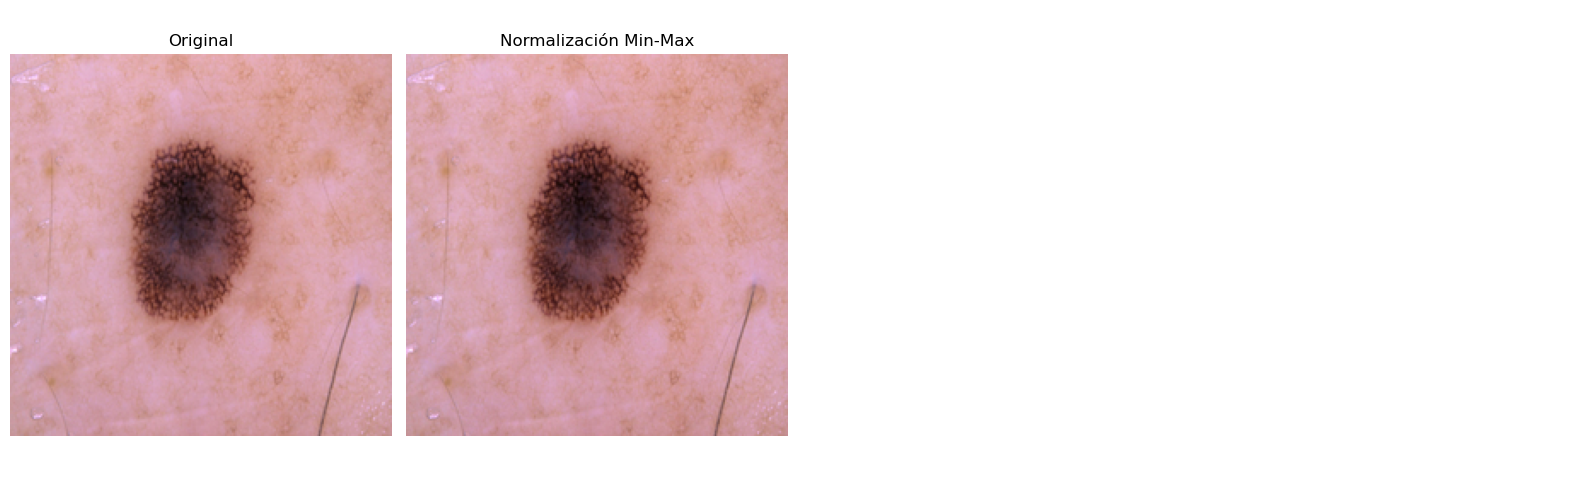

In [17]:
# Normalización de los datos
import numpy as np

def minmax_norm(img_arr):
    return (img_arr - img_arr.min()) / (img_arr.max() - img_arr.min())

# Ejemplo con una imagen:
from PIL import Image
img = np.array(Image.open(next((train_dir / classes[0]).glob("*")))).astype(np.float32)
norm_img = minmax_norm(img)
print("Antes:", img.min(),"-", img.max(), "→ Después:", norm_img.min(),"-", norm_img.max())

# Seleccionamos una imagen como ejemplo
img_path = next((train_dir / classes[0]).glob("*"))
img = Image.open(img_path)
img_array = np.array(img).astype(np.float32) # Convertir a float para las operaciones

# Visualizar resultados
fig, axs = plt.subplots(1, 4, figsize=(16, 5))
axs[0].imshow(img_array.astype(np.uint8))
axs[0].set_title('Original')
axs[1].imshow(norm_img)
axs[1].set_title("Normalización Min-Max")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

Se aplica normalización Min-Max para reescalar píxeles de [0,255] a [0,1]. Se busca preservar la distribución relativa de las intensidades.
Podría utilizarse Z-score, pero al usar Min.-Max los píxeles se mantienen en un rango acotado.
Se muestran la imagen original y posterior a la normalización Min-Max.

In [19]:
# Análisis descriptivo, revisión de las estadísticas globales
import numpy as np
from PIL import Image

# Leer N imágenes en escala de grises
N = 100
pix_vals = []
for i, p in enumerate((train_dir/classes[0]).glob("*")):
    if i>=N: break
    arr = np.array(Image.open(p).convert("L")).ravel()
    pix_vals.append(arr)
all_pixels = np.concatenate(pix_vals)

print("Media:",   all_pixels.mean())
print("Mediana:", all_pixels.mean())
print("Desviación Estándar:",  all_pixels.std())

Media: 158.6984610172194
Mediana: 158.6984610172194
Desviación Estándar: 33.23634534974363


Se aplanan todos los píxeles de un subconjunto (100) para el cálculo de la media, mediana y desviación estándar. De esta manera tenemos una idea del brillo medio del dataset y su dispersión.

            mean    median       std
mean    1.000000  0.953016 -0.127232
median  0.953016  1.000000  0.062607
std    -0.127232  0.062607  1.000000


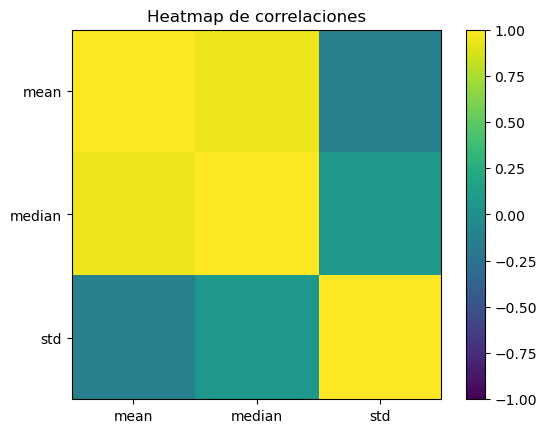

In [25]:
# Caracterís
import pandas as pd

records = []
for cls in classes:
    for p in (train_dir/cls).glob("*"):
        arr = np.array(Image.open(p).convert("L")).ravel()
        records.append({
            "clase":  cls,
            "mean":   arr.mean(),
            "median": np.median(arr),
            "std":    arr.std()
        })
df_feats = pd.DataFrame(records)

# Matriz de correlación
corr = df_feats[["mean","median","std"]].corr()
print(corr)

import numpy as np

# Matriz de correlación gráfica
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(3), corr.columns)
plt.yticks(np.arange(3), corr.columns)
plt.title("Heatmap de correlaciones")
plt.show()

Para cada imagen, se calcula la media, mediana y la desviación estándar. Con estos datos se construye un DataFrame con columna "clase", "mean", "median", "std" para la evaluación de correlación entre estas tres variables.
"mean" y "median" están muy correlacionados y "std" esta menos correlacionado (esto se demuestra gráficamente en el "Heatmap de correlaciones", esto podría indicar que la dispersión varía independientemente del brillo medio.

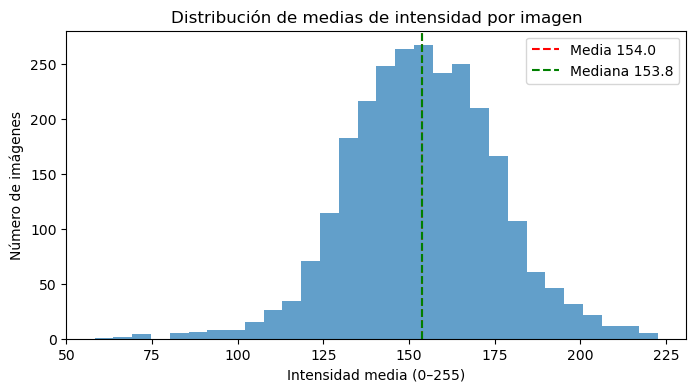

In [24]:
# Visualización de datos: Histograma de intensidades
import matplotlib.pyplot as plt

vals = df_feats["mean"] 
plt.figure(figsize=(8,4))
plt.hist(vals, bins=30, alpha=0.7)
plt.axvline(vals.mean(), color='red', linestyle='--', label=f"Media {vals.mean():.1f}")
plt.axvline(vals.median(), color='green', linestyle='--', label=f"Mediana {vals.median():.1f}")
plt.title("Distribución de medias de intensidad por imagen")
plt.xlabel("Intensidad media (0–255)")
plt.ylabel("Número de imágenes")
plt.legend()
plt.show()


El histograma de medias muestra que la mayoría de las imágenes concentra su brillo entre 58.21 y 222.78
La media global es de 154 y la mediana de 153.8.
La cercanía de estas dos líneas indica una distribución casi simétrica, ya que no hay imágenes extremadamente brillantes u oscuras que distorsionen el conjunto de datos.  
No se observan barras aisladas en los extremos, lo que sugiere ausencia de outliers severos en términos de brillo.  
Este perfil de iluminación homogénea facilita el proceso ya que reduce la necesidad de realizar correcciones adicionales de contraste o brillo.

<Figure size 600x400 with 0 Axes>

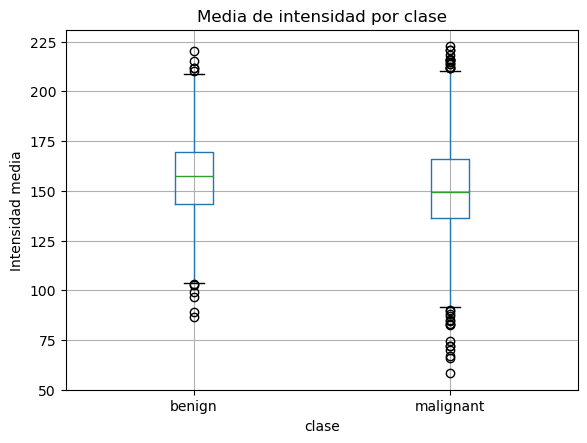

In [28]:
# Boxplot de medias por clase
plt.figure(figsize=(6,4))
df_feats.boxplot(column="mean", by="clase")
plt.title("Media de intensidad por clase")
plt.suptitle("")  # quita el título por defecto
plt.ylabel("Intensidad media")
plt.show()

En el gráfico se observa la distribución de medianas y cuartiles, se interpreta que las imágenes benignas (mediana ~155) presentan en promedio un brillo ligeramente mayor que las malignas (~150).
Se observa además una mayor dispersión de las intensidades medias en la clase "malignant", siendo en "benign" algo más homogénea.
En ambas clases se observan outliers, lo que representa imágenes muy oscuras o muy brillantes.
Se puede ver también que ambas clases compoarten niveles de intensidad similares.

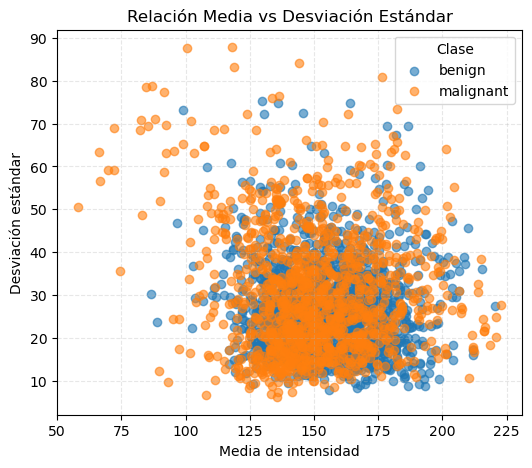

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))

# Scatter plot por clase
for cls in df_feats["clase"].unique():
    subset = df_feats[df_feats["clase"] == cls]
    plt.scatter(
        subset["mean"],
        subset["std"],
        alpha=0.6,
        label=cls
    )

plt.xlabel("Media de intensidad")
plt.ylabel("Desviación estándar")
plt.title("Relación Media vs Desviación Estándar")
plt.legend(title="Clase")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

En este gráfico es posible observar una ligera tendencia a la dispersión en las imágenes más brillante pero con mucho más solapamiento.